In [1]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

2025-08-20 16:08:42.644858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755706122.902341      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755706122.987316      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
BASE_DIR= "/kaggle/input/melanoma-cancer-dataset"
TRAIN_DIR=os.path.join(BASE_DIR,"train")
TEST_DIR=os.path.join(BASE_DIR,"test")

IMG_SIZE = (224,224)
BATCH_SIZE=32

train_datagen= ImageDataGenerator(
    rescale= 1./225,
    rotation_range= 20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip=True
)
    
test_datagen= ImageDataGenerator(rescale= 1./225)

train_generator= train_datagen.flow_from_directory(
    directory= TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"    #benign vs malignant
)


test_generator= test_datagen.flow_from_directory(
    directory= TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"  
)

print("class labels:", train_generator.class_indices)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
class labels: {'Benign': 0, 'Malignant': 1}


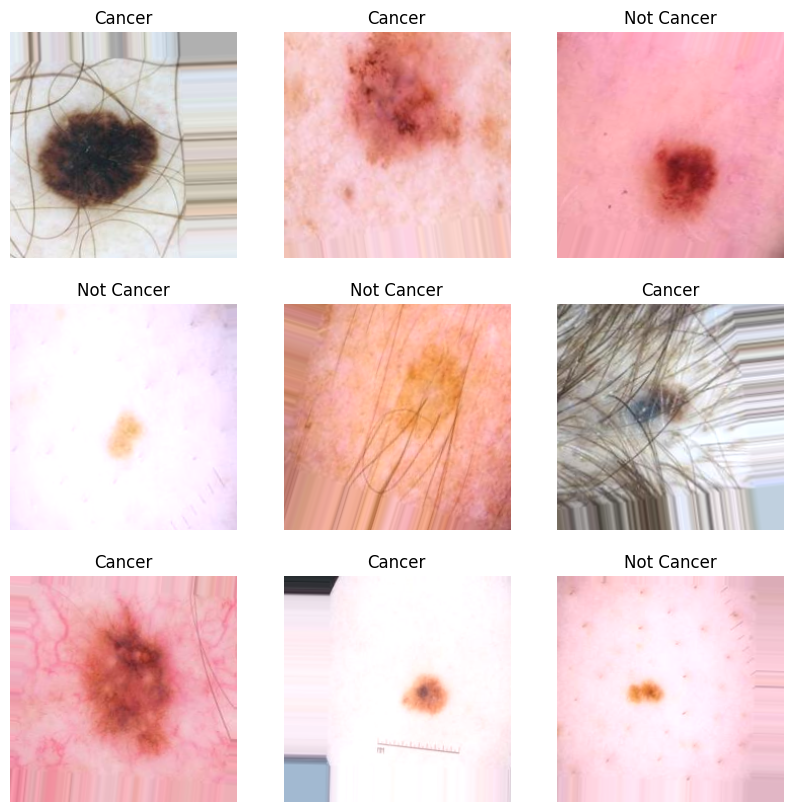

In [8]:
def plot_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i])
        plt.title('Cancer' if labels[i] == 1 else "Not Cancer")
        plt.axis('off')
    plt.show()

plot_images(train_generator)

In [9]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary classification (melanoma vs not)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training if validation loss doesn’t improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Reduce learning rate if validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch= train_generator.samples//BATCH_SIZE,
    epochs=5,
    validation_data= test_generator,
    validation_steps= test_generator.samples//BATCH_SIZE,
    callbacks=[early_stopping,lr_scheduler]
)

Epoch 1/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 947s 3s/step - accuracy: 0.7133 - loss: 0.6956 - val_accuracy: 0.7717 - val_loss: 0.4487 - learning_rate: 0.0010
Epoch 2/5
  1/371 ━━━━━━━━━━━━━━━━━━━━ 13:45 2s/step - accuracy: 0.8125 - loss: 0.4003

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


371/371 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - accuracy: 0.8125 - loss: 0.4003 - val_accuracy: 0.7500 - val_loss: 0.4875 - learning_rate: 0.0010
Epoch 3/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 945s 3s/step - accuracy: 0.8175 - loss: 0.4055 - val_accuracy: 0.8382 - val_loss: 0.3633 - learning_rate: 0.0010
Epoch 4/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - accuracy: 0.7500 - loss: 0.3988 - val_accuracy: 0.8453 - val_loss: 0.3426 - learning_rate: 0.0010
Epoch 5/5
371/371 ━━━━━━━━━━━━━━━━━━━━ 940s 3s/step - accuracy: 0.8367 - loss: 0.3750 - val_accuracy: 0.8438 - val_loss: 0.3322 - learning_rate: 0.0010


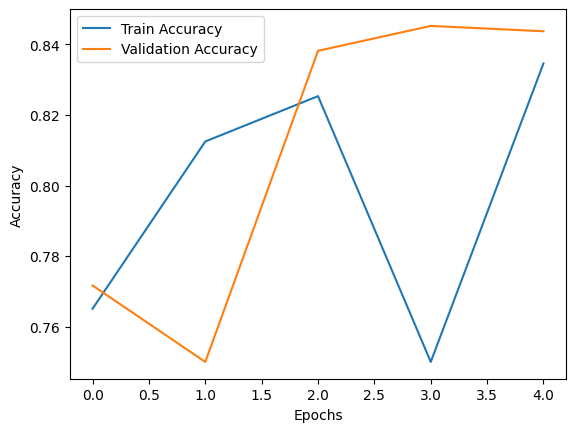

In [13]:
model.save("cnn_cancer_model.h5")
model.save("skin_cancer_cnn.h5")

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [17]:
test_pred=model.predict(test_generator, steps= test_generator.samples // BATCH_SIZE, verbose= 1)
test_pred_labels= (test_pred > 0.5). astype('int32')
test_pred_labels

test_true_labels= test_generator.classes[:len(test_pred_labels)]
print(classification_report(test_true_labels, test_pred_labels))



62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 605ms/step
              precision    recall  f1-score   support

           0       0.52      0.56      0.54      1000
           1       0.51      0.46      0.49       984

    accuracy                           0.51      1984
   macro avg       0.51      0.51      0.51      1984
weighted avg       0.51      0.51      0.51      1984



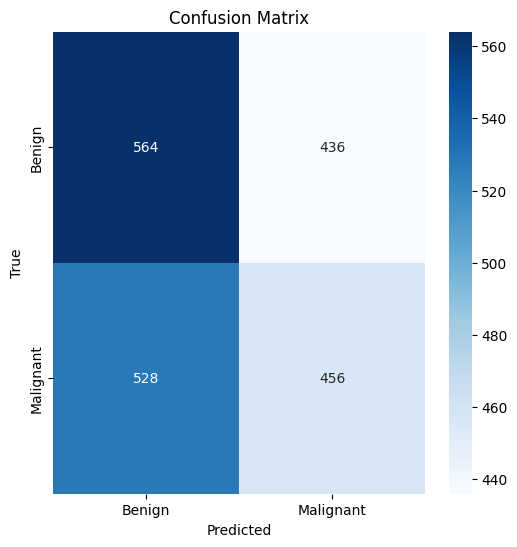

In [18]:
cm= confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot= True, fmt='d',cmap='Blues',xticklabels=train_generator.class_indices.keys(),yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [36]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

model=load_model("/kaggle/working/skin_cancer_cnn.h5")

from tensorflow.keras.preprocessing import image
import numpy as np

def predict_skin_cancer(image_path, model):
    
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    
    prediction = model.predict(img_array)
    prob = prediction[0][0]

    # Binary classification: threshold at 0.5
    class_label = 'Malignant' if prediction[0][0] > 0.5 else 'Benign'

    plt.imshow(image.load_img(image_path))
    plt.axis("off")
    plt.title(f"Prediction: {class_label} ({prob:.2f})")
    plt.show()

    return class_label, prob


    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


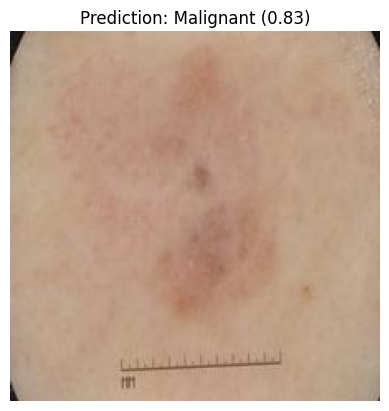

('Malignant', 0.8268661)

In [37]:
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/train/Malignant/1004.jpg",model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


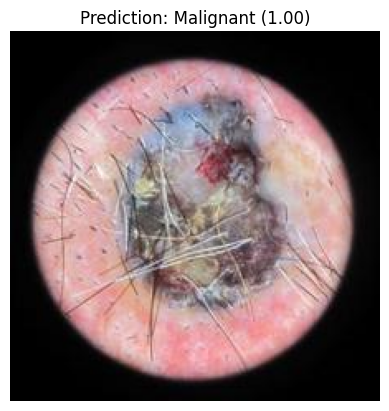

('Malignant', 0.9997018)

In [39]:
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/test/Malignant/5616.jpg",model)